In [1]:
from lisa.utils import *
from lisa.library import *
import lisa.models
import numpy as np, pandas as pd, datetime
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

In [2]:
style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
datastream = DataSet.objects.get(id=3)
df = datastream.dataframe
print(df.shape)

(720, 10)


In [8]:
df_class = pd.DataFrame(index=df.index)
df_class['Class'] = 0
df_class.loc[datetime.datetime(2017, 4, 2, 21, 0, tzinfo=pytz.utc),'Class'] = 1
df_class.loc[datetime.datetime(2017, 4, 4, 18, 0, tzinfo=pytz.utc),'Class'] = 1
df_class.loc[datetime.datetime(2017, 4, 14, 8, 0, tzinfo=pytz.utc),'Class'] = 1
df_class.loc[datetime.datetime(2017, 4, 20, 9, 0, tzinfo=pytz.utc),'Class'] = 1
df_class.loc[datetime.datetime(2017, 4, 29, 19, 0, tzinfo=pytz.utc),'Class'] = 1
df_class.loc[datetime.datetime(2017, 4, 29, 3, 0, tzinfo=pytz.utc),'Class'] = 1
df = df.join(df_class)

In [9]:
normal = df[df['Class'] == 0]
anomaly = df[df['Class'] == 1]
print(normal.shape)
print(anomaly.shape)

(714, 11)
(6, 11)


In [13]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.5, random_state=42)
print('Normal_Test Shape', normal_test.shape)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Normal_Test Shape (357, 11)
Train shape:  (357, 11)
Proportion os anomaly in training set: 0.00

Valid shape:  (181, 11)
Proportion os anomaly in validation set: 0.02

Test shape:,  (182, 11)
Proportion os anomaly in test set: 0.02



In [19]:
from scipy.stats import multivariate_normal

mu = train.drop('Class', axis=1).mean(axis=0).values
sigma = train.drop('Class', axis=1).cov().values
model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

print(np.median(model.logpdf(valid[valid['Class'] == 0].drop('Class', axis=1).values))) 
print(np.median(model.logpdf(valid[valid['Class'] == 1].drop('Class', axis=1).values))) 

-7.47407814286
-88.3349358911


In [26]:
tresholds = np.linspace(-100,0, 10)
scores = []
for treshold in tresholds:
    y_hat = (model.logpdf(valid.drop('Class', axis=1).values) < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=1)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())
print(scores)

1.0 7
[[ 0.33333333  1.          0.5       ]
 [ 0.33333333  1.          0.5       ]
 [ 0.66666667  1.          0.8       ]
 [ 0.66666667  1.          0.8       ]
 [ 0.66666667  1.          0.8       ]
 [ 0.66666667  1.          0.8       ]
 [ 0.66666667  1.          0.8       ]
 [ 1.          1.          1.        ]
 [ 1.          1.          1.        ]
 [ 1.          0.01657459  0.0326087 ]]


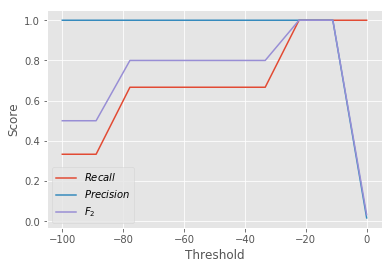

In [27]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: -22
Test Recall Score: 0.667
Test Precision Score: 0.800
Test F1 Score: 0.727


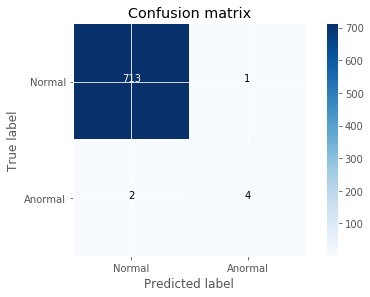

In [42]:
final_tresh = tresholds[scores[:, 2].argmax()]
df_n = df.reset_index(drop=True)
y_hat_test = (model.logpdf(df_n.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=df_n['Class'].values, beta=1))

cnf_matrix = confusion_matrix(df_n['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal']
                      , title='Confusion matrix')

In [45]:
unique, counts = np.unique(y_hat_test, return_counts=True)
dict(zip(unique, counts))

{0: 715, 1: 5}

In [48]:
(df_n.drop('Class', axis=1).values) < final_tresh)

SyntaxError: invalid syntax (<ipython-input-48-8a99e4fb460b>, line 1)